In [90]:
#Importation des bibilotèques python

%matplotlib inline
from os import listdir, chdir, getcwd
from os.path import isfile, join, abspath
from sorcery import dict_of

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from scipy.optimize import curve_fit



In [149]:
# Fichiers est une liste contenant le nom de tout les fichier de données

fichiers = [f for f in listdir("Dataset") if isfile(join("Dataset", f))]


# Création d'une liste de données (data). Chaque élément de la liste (data[i]) est un fichier NETCDF4 

data = []

for i in range(len(fichiers)) :
    data.append(nc.Dataset('Dataset/' + fichiers[i]))
    
    
# Au choix, une ville 
ville = data[24]


In [150]:
# Création des variables contenant les grandeurs d'interet 

second = ville.variables['time'][:]
day = ville.variables['day'][:]
year = ville.variables['year'][:]
xco2 = ville.variables['xco2'][:]
err_xco2 = ville.variables['xco2_error'][:]
flag_xco2 = ville.variables['extrapolation_flags_ak_xco2'][:]
hour = ville.variables['hour'][:]
month = ville.variables['day'][:]*0       # Le mois de l'année sera défini plus loin, il est juste mis à zero
day_cumul = ville.variables['day'][:]*0   # Calculé ensuite 


# Création d'une dataframe pandas. Chaque clé du dico correpond à une colonne
a1 = pd.DataFrame(dict_of(second,day,year,xco2,err_xco2,flag_xco2))



# Autre façon de faire, les années et les jours deviennent des sous labels plutot que des colonnes.
# Peut être pratique
arrays = [np.array(year) , np.array(day)]

a2 = pd.DataFrame({'xCO2':xco2 , 'flag_co2': flag_xco2  }, index=arrays)
a2.index.names = (['year','day'])

In [151]:
#Ajout du mois de l'année dans la colonne month

# Définir une fonction qui prend le numéro du jour de l'année en entrée et renvoie le mois correspondant
def day_to_month(num_jour):
    jours_par_mois = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    jours_ecoules = 0
    for mois in range(12):
        jours_ecoules += jours_par_mois[mois]
        if jours_ecoules >= num_jour:
            return int(mois + 1)

# Appliquer la fonction à chaque valeur de la colonne "jour_de_l_annee" pour créer une nouvelle colonne "mois_de_l_annee"
a1['month'] = a1['day'].apply(day_to_month)


# Ajout du jour cumulé dans la colonne jour_cumul

a1['day_cumul'] = 365 * a1['year'] + a1['day']
a1['day_cumul'] = a1['day_cumul'] - min(a1['day_cumul'])


In [152]:
# Filtrage des data en fonction du flag xco2
a1 = a1[a1['flag_xco2'] >= 0]


In [153]:
# Calcul moyenne journalière

# Groupby permet de portionner la dataframe selon les valeurs des colonnes spécifiées
day_mean_xco2 = a1.groupby(['year','day'])['xco2'].mean()   # Moyenne journaliere de xCO2 
day_std_xco2 = a1.groupby(['year','day'])['xco2'].std()   # Standard deviation de cette moyenne 
day_count_measurement = a1.groupby(['year','day'])['xco2'].count() # Nombre de mesure de dans la journée 

#Calcul de la moyenne annuelle
year_mean_xco2 = a1.groupby(['year'])['xco2'].mean()   # Moyenne journaliere de xCO2 
year_std_xco2 = a1.groupby(['year'])['xco2'].std()   # Standard deviation de cette moyenne 
year_count_measurement = a1.groupby(['year'])['xco2'].count() # Nombre de mesure de dans la journée 



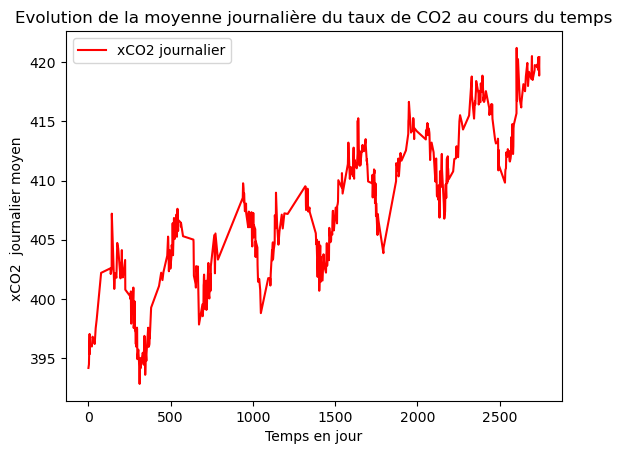

In [154]:
# Plot de la moyenne journalière de xCO2

x = a1['day_cumul'].unique()
y = day_mean_xco2
yerr = day_std_xco2


# Créer un graphique avec x en fonction de y
plt.plot(x, y, 'r-', label='xCO2 journalier')
# Ajouter des barres d'erreur vertes à partir de yerr
#plt.errorbar(x, y, yerr=yerr, ecolor='g', capsize = 0.1,fmt = 'None')


plt.title('Evolution de la moyenne journalière du taux de CO2 au cours du temps')
plt.xlabel('Temps en jour')
plt.ylabel('xCO2  journalier moyen ')
plt.legend()

plt.show()


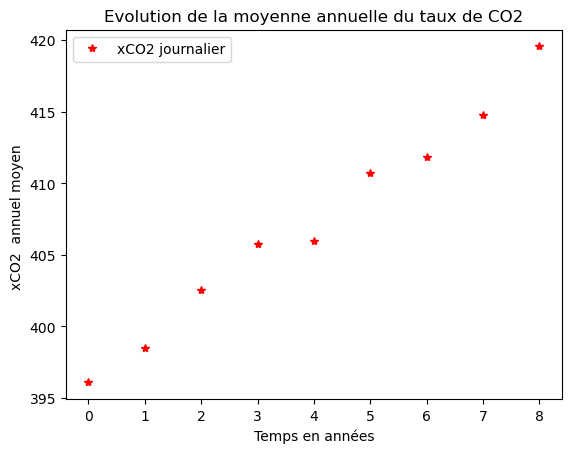

In [155]:
# Plot de la moyenne annuelle de xCO2

borne_mesure_valable = 100 ; # Souhaite afficher les points suffisemment moyennés  
x = range(len(year_mean_xco2[year_count_measurement>borne_mesure_valable]))
y = year_mean_xco2[year_count_measurement>borne_mesure_valable]
yerr = year_std_xco2[year_count_measurement>borne_mesure_valable]


# Créer un graphique avec x en fonction de y
plt.plot(x, y, 'r*', label='xCO2 journalier')
# Ajouter des barres d'erreur vertes à partir de yerr
#plt.errorbar(x, y, yerr=yerr, ecolor='g', capsize = 0.1,fmt = 'None')


plt.title('Evolution de la moyenne annuelle du taux de CO2')
plt.xlabel('Temps en années')
plt.ylabel('xCO2  annuel moyen ')
plt.legend()

plt.show()



A = 0.006786212197115952
B = -3.621570156681735
C = 0.017223088049752797
D = -12.24314283204671
E = 398.3528103135443


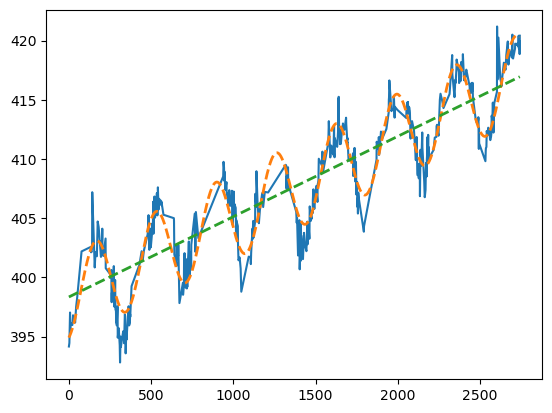

In [180]:
# On fit l'evolution annuelle de xCO2 par une fonction
x = a1['day_cumul'].unique()
y = day_mean_xco2
yerr = day_std_xco2


# La fonction du modèle
def func_fit_1(t, A, B, C,D,E):
    return A * t + B * np.cos(C * t + D)+ E



# Ajuster les paramètres du modèle aux données
guess = [10, 0.1, 2* np.pi/365, 0, 395]  # On donne au modèle un guess initial des paramètres, sinon il galère 
popt, pcov = curve_fit(func_fit_1,x , y,guess)
xfit = range(min(x),max(x),1)

# Afficher les paramètres A, B et C ajustés
print('A =', popt[0])
print('B =', popt[1])
print('C =', popt[2])
print('D =', popt[3])
print('E =', popt[4])

plt.plot(x,y)
plt.plot(xfit,func_fit_1(xfit,popt[0],popt[1] ,popt[2],popt[3],popt[4]),ls='--',lw=2)
plt.plot(x,popt[0]* x + popt[4],ls='--',lw = 2)


In [ ]:
# On met toute les villes dans une meme Dataframe

all_data = pd.DataFrame()

for i in range(len(data)) :

    ville = data[i]
    
    second = ville.variables['time'][:]
    day = ville.variables['day'][:]
    year = ville.variables['year'][:]
    xco2 = ville.variables['xco2'][:]
    err_xco2 = ville.variables['xco2_error'][:]
    flag_xco2 = ville.variables['extrapolation_flags_ak_xco2'][:]
    lat = ville.variables['lat']
    
    
    
    df_ville = pd.DataFrame(dict_of(second,day,year,xco2,err_xco2,flag_xco2))
    
               
    all_data = pd.concat([all_data, df_ville], axis = 0 )
    


In [35]:
for i in ville.variables:
    print(i)

time
prior_time
prior_altitude
ak_altitude
ak_pressure
ak_xco2
extrapolation_flags_ak_xco2
ak_xwco2
extrapolation_flags_ak_xwco2
ak_xlco2
extrapolation_flags_ak_xlco2
ak_xch4
extrapolation_flags_ak_xch4
ak_xhf
extrapolation_flags_ak_xhf
ak_xo2
extrapolation_flags_ak_xo2
ak_xn2o
extrapolation_flags_ak_xn2o
ak_xco
extrapolation_flags_ak_xco
ak_xh2o
extrapolation_flags_ak_xh2o
prior_temperature
prior_pressure
prior_density
prior_h2o
prior_co2
prior_n2o
prior_co
prior_ch4
prior_o2
prior_hf
prior_hdo
prior_gravity
prior_equivalent_latitude
prior_tropopause_altitude
prior_effective_latitude
prior_mid_tropospheric_potential_temperature
gfit_version
gsetup_version
year
day
hour
lat
long
zobs
zmin
solzen
azim
tout
pout
hout
sia
fvsi
wspd
wdir
xluft
xluft_error
xhf
xhf_error
xh2o
xh2o_error
xhdo
xhdo_error
xco
xco_error
xn2o
xn2o_error
xch4
xch4_error
xlco2_experimental
xlco2_error_experimental
xwco2_experimental
xwco2_error_experimental
xco2
xco2_error
ak_xhdo
extrapolation_flags_ak_xhdo
xco2_x

In [ ]:
# Idées et questions 

# Soustraire l'evolution anuelle  pour observer les cycles saisonniers 
# Faire moyenne glissante sur les années pour lisser 
# Ville / Pas ville 
# Hemisphere nord / Hemisphere sud 
# Amplitude saisonniere 
# Tendance d'évolution générale
# Amplitude quotidienne 




# C'est quoi prior ? c'est quoi ak ? 




